# Kaggle: Training a Model to Classify Images of Pets
**The training archive contains 25,000 images of dogs and cats. Train your algorithm on these files and predict the labels for test1.zip (1 = dog, 0 = cat)**
https://www.kaggle.com/c/dogs-vs-cats/data

In [1]:
from os import listdir
from os.path import isfile, join
import re
import matplotlib.pyplot as plt
from matplotlib import pyplot

import numpy as np

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#### This first cell loads the images from the cat and dog folders and turn them into arrays.

In [16]:
images_to_use = 300 # increase this number if you want to use more data

cat_path = '/Users/mucongl/Downloads/data/UCLA_ML/hw4_deep_learning_images/cat' # edit with the path to the folder with your cat data
dog_path = '/Users/mucongl/Downloads/data/UCLA_ML/hw4_deep_learning_images/dog' # edit with the path to the folder with your dog data
dog_files = [dog_path + "/" + f for f in listdir(dog_path) if isfile(join(dog_path, f))][:images_to_use]
cat_files = [cat_path + "/" + f for f in listdir(cat_path) if isfile(join(cat_path, f))][:images_to_use]

files = dog_files + cat_files

X = []
y = []


for file in files:
    label = file.split('/')[7] # gets the folder name
    y.append(label)
    img = load_img(file, target_size=(224, 224))
    img = img_to_array(img)
    X.append(img)

#### The following cell splits the data into train, validation and test. 
- It performs transformations to turn a colored image, which has 3 values per pixel in the RGB color model (https://en.wikipedia.org/wiki/RGB_color_model), into a matrix of single values that combine the 3 RGB values.

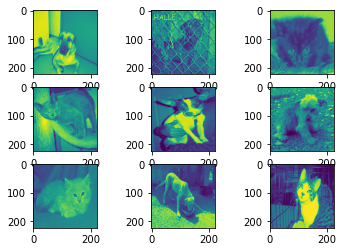

In [17]:
from sklearn.model_selection import train_test_split

def flatten_X(X):
    return np.vstack([arr.flatten() for arr in X])

def rgb2gray(rgb):
    # this converts the RGB colors to gray, so you have only one value per pixel
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140]) 

def transform_to_gray_features(X):
    gray_features = []
    for instance in X:
        X_gray = rgb2gray(instance)
        flattened_X_gray = X_gray.flatten()
        gray_features.append(flattened_X_gray)
    return np.vstack(gray_features)

def get_train_val_test(X, y, split=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
    return X_train, y_train, X_test, y_test, X_val, y_val

X_train, y_train, X_test, y_test, X_val, y_val = get_train_val_test(X, y, split=0.2)

X_train_gray = transform_to_gray_features(X_train)
X_test_gray = transform_to_gray_features(X_test)
X_val_gray = transform_to_gray_features(X_val)



# plot first few images with the gray transform
for i in range(9):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # define filename
    
    # plot raw pixel data
    pyplot.imshow(rgb2gray(X_train[i]))
# show the figure
pyplot.show()

## Approach 1: Train a model using the gray scaled features

In [50]:
# What is the size of your feature vector?

X_train_gray.shape

(480, 50176)

**What is the size of the feature vector?**
- The size of feature vector is (480, 50176)
- This means that there are 480 instances, which are all images with 224*224 pixels
- It shows as 50176 instead of (480, 224, 224) because of the gray transformation, which performs transformations to turn a colored image, which has 3 values per pixel in the RGB color model, into a matrix of single values that combine the 3 RGB values.

In [53]:
%%time
# Add code here to train a model on the training data.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': [1,5,10,20]}

gsearch = GridSearchCV(RandomForestClassifier(), param_grid, n_jobs=-1, scoring = 'f1_macro')
gsearch.fit(X_train_gray, y_train)
print("Best parameter (CV score=%0.3f):" % gsearch.best_score_)
print(gsearch.best_params_)
y_pred = gsearch.predict(X_train_gray)
print(classification_report(y_train, y_pred))

Best parameter (CV score=0.609):
{'max_depth': 5}
              precision    recall  f1-score   support

         cat       1.00      0.98      0.99       242
         dog       0.98      1.00      0.99       238

    accuracy                           0.99       480
   macro avg       0.99      0.99      0.99       480
weighted avg       0.99      0.99      0.99       480

CPU times: user 2.65 s, sys: 84.7 ms, total: 2.73 s
Wall time: 8.05 s


#### Use the classification report function from sklearn to show evaluate the results.

In [54]:
y_pred = gsearch.predict(X_val_gray)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         cat       0.52      0.52      0.52        27
         dog       0.61      0.61      0.61        33

    accuracy                           0.57        60
   macro avg       0.56      0.56      0.56        60
weighted avg       0.57      0.57      0.57        60



The model is better at predicting dog (from result on the validation set)


## Using Pre-trained models to extract features

In the cell below, we import the VGG16 model. I also have commented out the commands to use other existing pre-trained models from Keras.

In [22]:
from keras.applications.vgg16 import VGG16
# from keras.applications import ResNet50
# from keras.applications import InceptionV3
# from keras.applications import Xception # TensorFlow ONLY
# from keras.applications import VGG16
# from keras.applications import VGG19


model = VGG16(weights='imagenet', include_top=False,input_shape=(224, 224, 3))
model.summary()

58892288/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

#### Extract the features using the pre-trained model:
- Because we pass the flag `include_top=False` when loading the model, we get the vector of the last layer of the model before going through the Softmax function, instead of the model predictions. 
- This vector should contain information about what is in the image.

In [23]:
def extract_features_from_images(images):
    # Receives an array of images and transform it into an array of features from DL models
    features = []
    
    for img in images:
        img_proper_shape = np.expand_dims(img, axis=0) # adds another axis required by DL models 
        extracted_features = model.predict(img_proper_shape)
        flattened_features = extracted_features.flatten() # We make a single 1D array to represent the features
        features.append(flattened_features)
        
    return np.vstack(features)

In [24]:
X_train_features = extract_features_from_images(X_train)

In [25]:
X_test_features = extract_features_from_images(X_test)
X_val_features = extract_features_from_images(X_val)

## Approach 2: Using the features extracted from pre-trained models

- I used the same model I have used for Approach 1
- but now train it on X_train_features, the features extracted using the Deep Learning models

In [57]:
X_train_features.shape

(480, 25088)

In [55]:
%%time
# Add code to train a model on the features extracted using the Deep Learning model

param_grid = {'max_depth': [1,5,10,20]}

gsearch = GridSearchCV(RandomForestClassifier(), param_grid, n_jobs=-1, scoring = 'f1_macro')
gsearch.fit(X_train_features, y_train)
print("Best parameter (CV score=%0.3f):" % gsearch.best_score_)
print(gsearch.best_params_)
y_pred = gsearch.predict(X_train_features)
print(classification_report(y_train, y_pred))

Best parameter (CV score=0.937):
{'max_depth': 20}
              precision    recall  f1-score   support

         cat       1.00      1.00      1.00       242
         dog       1.00      1.00      1.00       238

    accuracy                           1.00       480
   macro avg       1.00      1.00      1.00       480
weighted avg       1.00      1.00      1.00       480

CPU times: user 1.01 s, sys: 26 ms, total: 1.04 s
Wall time: 3.06 s


#### This algorithm is way faster than the previous one.
- Because the size of the feature vector is way smaller: (480, 25088)
- This is because the VGG16 model extracts features that indicate what is in the image

#### Classification report results on the test set

In [56]:
y_pred = gsearch.predict(X_test_features)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         cat       0.93      0.90      0.92        31
         dog       0.90      0.93      0.92        29

    accuracy                           0.92        60
   macro avg       0.92      0.92      0.92        60
weighted avg       0.92      0.92      0.92        60



## Result
- Greatly improved
- Test set score: f1_macro = 0.92

## Steps taken:
- The steps taken to train the Random Forest model is the same as above.
- I used the GridSearchCV method to find the best hyper-parameter for the Random Forest model, used this model to predict on the test set, and made classification report on the test set.
- The differences in results are due to the pre-trained model VGG16 that was appleid to the X_train set.
- VGG16 is a Convolutional Network for Classification and Detection, which shrinks the RGB layers to create denser representation of images. 
- After that, we feed the result of these denser representations to the Random Forest, and these denser representations greatly improve the results.